# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from ma_ddpg import MADDPG

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        print(rewards)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [4]:
def fill_memory(agent, n_fill_episodes=10000):
    to_fill = agent.buffer_size*0.5
    pos_ratio = 0.3
    neg_ratio = 0.3
    neutral_ratio = 0.4
    # counter for number of experiences of each type
    pos_actual = 0
    neg_actual = 0
    neu_actual = 0
    
    for i_episode in range(1, n_fill_episodes+1):
        # reset at each episode
        env_info = env.reset(train_mode=True)[brain_name] 
        # get all agents states
        states = env_info.vector_observations
        while True:
            actions = np.random.randn(2, 2)              
            actions = np.clip(actions, -1, 1)                       
            env_info = env.step(actions)[brain_name]     
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done 
            if len(agent.memory)< to_fill:
                # reshape data to be compatible with buffer 
                state = states.reshape(1, -1)  
                next_state = next_states.reshape(1, -1)  
                action= np.array(actions).reshape(1, -1)
                if np.mean(rewards)>0 and (pos_actual/to_fill)<=pos_ratio:
                    agent.memory.add(state, action, rewards, next_state, dones)
                    #update counter
                    pos_actual+=1
                if np.mean(rewards)<0 and (neg_actual/to_fill)<=neg_ratio:
                    agent.memory.add(state, action, rewards, next_state, dones)
                    neg_actual+=1
                if ((np.mean(rewards)==0) and ((neu_actual/to_fill)<=neutral_ratio)):
                    agent.memory.add(state, action, rewards, next_state, dones)
                    neu_actual+=1
                # agent.memory.add(state, action, rewards, next_state, dones)
            states = next_states
            # if episode is finished
            if np.any(dones):
                break
        actual_pos = pos_actual/to_fill
        neg_pos = neg_actual/to_fill
        neu_pos = neu_actual/to_fill
        # print('\rEpisode {}\tMemory Size: {}'.format(i_episode, len(agent.memory)), end="")
        print('\rEpisode {}\tPos: {:.5}\tNeg: {:.5f}\tNeu: {:.5f}\tFill :{}\tNow : {}\t'.format(i_episode, actual_pos,neg_pos,neu_pos,to_fill, len(agent.memory)), end="")
        if len(agent.memory) >= to_fill:
            break

In [5]:
def maddpg_train(agent, n_episodes=150000, print_every=100):                              
    np.random.seed(1)
    torch.manual_seed(1)
   
    scores_deque = deque(maxlen=print_every)
    scores_all = []
    num_agents = len(agent.agents)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        while True:
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)     
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        max_score = np.max(scores)
        scores_deque.append(max_score)
        scores_all.append(max_score)
        print('\rEpisode {}\tAverage Score: {:.5f}\t Max Score: {:.5f}\tReward this episode: {}'.format(i_episode, np.mean(scores_deque), np.max(scores_deque),scores), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.5f} '.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.5:
            print('\rSolved in {} episode\tAverage Score {:.5f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.agents[0].actor_local.state_dict(),'check_pt_actor.pth')
            torch.save(agent.agents[0].critic_local.state_dict(),'check_pt_critic.pth')
            break
    return scores_all

In [6]:
agent = MADDPG(2, 24, 2)
fill_memory(agent)

Episode 10000	Pos: 0.04356	Neg: 0.19928	Neu: 0.40002	Fill :50000.0	Now : 32143	

Episode 100	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 200	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 300	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 400	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 500	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 600	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [-0.01  0.  ]
Episode 700	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [-0.01  0.  ]
Episode 800	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [-0.01  0.  ]
Episode 900	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 1000	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 1100	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [-0.01  0.  ]
Episode 

Episode 9100	Average Score: 0.00100  Max Score: 0.10000	Reward this episode: [-0.01  0.  ]
Episode 9200	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 9300	Average Score: 0.00100  Max Score: 0.10000	Reward this episode: [ 0.   -0.01]
Episode 9400	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 9500	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 9600	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [-0.01  0.  ]
Episode 9700	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [ 0.   -0.01]
Episode 9800	Average Score: 0.00000  Max Score: 0.00000	Reward this episode: [-0.01  0.  ]
Episode 9900	Average Score: 0.01610  Max Score: 0.10000	Reward this episode: [-0.01  0.  ]
Episode 10000	Average Score: 0.03200  Max Score: 0.10000	Reward this episode: [0.   0.09]]
Episode 10100	Average Score: 0.02870  Max Score: 0.10000	Reward this episode: [-0.01  0.  

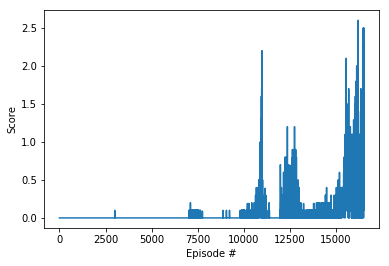

<Figure size 432x288 with 0 Axes>

In [7]:
scores_all = maddpg_train(agent)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig("results.png")